# Przykładowy projekt z przetwarzania danych
Autor: Andrzej Manujło



  
Pliki z danymi należy umieścić w tym samym katalogu co notebook

## Import potrzebnych biblotek
do obsługi plików xml i csv oraz pakietów numpy i pandas

In [0]:
from xml.etree import cElementTree
import csv
import pandas as pd
import numpy as np

In [0]:
!wget --no-check-certificate \
     https://archive.org/download/stackexchange/travel.stackexchange.com.7z \
    -O /tmp/plik.tar.7z



--2020-03-23 14:24:02--  https://archive.org/download/stackexchange/travel.stackexchange.com.7z
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia600107.us.archive.org/27/items/stackexchange/travel.stackexchange.com.7z [following]
--2020-03-23 14:24:02--  https://ia600107.us.archive.org/27/items/stackexchange/travel.stackexchange.com.7z
Resolving ia600107.us.archive.org (ia600107.us.archive.org)... 207.241.227.247
Connecting to ia600107.us.archive.org (ia600107.us.archive.org)|207.241.227.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114668451 (109M) [application/x-7z-compressed]
Saving to: ‘/tmp/plik.tar.7z’

/tmp/plik.tar.7z    100%[===================>] 109.36M  1.72MB/s    in 48s     

2020-03-23 14:24:50 (2.26 MB/s) - ‘/tmp/plik.tar.7z’ saved [114668451/114668451]



In [0]:
!7z e /tmp/plik.tar.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /tmp/               1 file, 114668451 bytes (110 MiB)

Extracting archive: /tmp/plik.tar.7z
--
Path = /tmp/plik.tar.7z
Type = 7z
Physical Size = 114668451
Headers Size = 335
Method = BZip2
Solid = +
Blocks = 5

  0%      2% - Badges.xml                   4% 1 - Comments.xml                       5% 1 - Comments.xml                       6% 1 - Comments.xml                       7% 1 - Comments.xml                       9% 1 - Comments.xml                      10% 1 - Comme

In [0]:
ls 


Badges.xml    PostHistory.xml  Posts.xml     Tags.xml   Votes.xml
Comments.xml  PostLinks.xml    sample_data/  Users.xml


# 1. Wczytanie danych i zapis do plików CSV, stworzenie DataFarmes z danymi

## Stworzenie słownika SEDE ze strukturą danych w plikach i typami danych
źródła:  
https://ia800107.us.archive.org/27/items/stackexchange/readme.txt  
https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede


In [0]:

SEDE = {
  'Badges': {
    'Id': 'int32',
    'UserId': 'int32',
    'Class': 'int32',
    'Name': 'str',
    'Date': 'str',
    'TagBased': 'bool',
  },
  'Comments': {
    'Id': 'int32',
    'PostId': 'int32',
    'Score': 'int32',
    'Text': 'str',
    'CreationDate': 'str',
    'UserId': 'float',
    'UserDisplayName': 'str'
  },
  'Posts': {
      'Id': 'int32',
      'PostTypeId': 'int32',
      'ParentId': 'float',
      'AcceptedAnswerId': 'float',
      'CreationDate': 'str',
      'Score': 'int32',
      'ViewCount': 'float',
      'Body': 'str',
      'OwnerUserId': 'float',
      'OwnerDisplayName': 'str',
      'LastEditorUserId': 'float',
      'LastEditorDisplayName': 'str',
      'LastEditDate': 'str',
      'LastActivityDate': 'str',
      'CommunityOwnedDate': 'str',
      'Title': 'str',
      'Tags': 'str',
      'AnswerCount': 'float',
      'CommentCount': 'float',
      'FavoriteCount': 'float',
      'ClosedDate': 'str'
  },
  'Votes': {
      'Id': 'int32',
      'PostId': 'int32',
      'UserId': 'float',
      'VoteTypeId': 'int32',
      'CreationDate': 'str',
      'BountyAmount': 'float'
  },
  'PostHistory': {
      'Id': 'int32',
      'PostHistoryTypeId': 'int32',
      'PostId': 'int32',
      'RevisionGUID': 'str',
      'CreationDate': 'str',
      'UserId': 'float',
      'UserDisplayName': 'str',
      'Comment': 'str',
      'Text': 'str'
  },
  'PostLinks': {
      'Id': 'int32',
      'CreationDate': 'str',
      'PostId': 'int32',
      'RelatedPostId': 'int32',
      'PostLinkTypeId': 'float',
      'LinkTypeId': 'int32'
  },
  'Users': {
      'Id': 'int32',
      'Reputation': 'int32',
      'CreationDate': 'str',
      'DisplayName': 'str',
      'LastAccessDate': 'str',
      'WebsiteUrl': 'str',
      'Location': 'str',
      'Age': 'float',
      'AboutMe': 'str',
      'Views': 'int32',
      'UpVotes': 'int32',
      'DownVotes': 'int32',
      'AccountId': 'float',
      'ProfileImageUrl': 'str'
  },
  'Tags': {
      'Id': 'int32',
      'TagName': 'str',
      'Count': 'int32',
      'ExcerptPostId': 'float',
      'WikiPostId': 'float'
  }
}
for file_name in SEDE:
    print(file_name)
    
#wydrukowanie nazw df do stworzenia

Badges
Comments
Posts
Votes
PostHistory
PostLinks
Users
Tags


In [0]:
for dfname in SEDE:
    exec('{} = pd.DataFrame()'.format(dfname))
#  przygotowanie nazw do zapisu plików CSV 

## Pętla do stworzenia plików CSV z XML:

In [0]:
def parserek(fh,filename):
    events = cElementTree.iterparse(fh)
    for event, elem in events:
        if elem.tag != 'row':
            continue
        result = []
        for key in SEDE[filename]:
            try:
                result.append(elem.attrib[key])
            except KeyError:
                result.append('')
        yield result
        elem.clear()
for file_name in SEDE:
    print('Read: ',file_name)
    writer = csv.writer(open(file_name+'.csv', 'w'))
    for line in parserek(open(file_name+'.xml'),file_name):
        writer.writerow(line)

Read:  Badges
Read:  Comments
Read:  Posts
Read:  Votes
Read:  PostHistory
Read:  PostLinks
Read:  Users
Read:  Tags


## Wczytanie danych z plików CSV do Pandas DataFrame wraz z nazwanmiem odpowiednich kolumn korzystając ze słownika SEDE

In [0]:
Badges = pd.read_csv('Badges.csv', header=None, names=SEDE['Badges'], dtype = SEDE['Badges'] )
Comments = pd.read_csv('Comments.csv', header=None, names=SEDE['Comments'], dtype = SEDE['Comments'])
Posts = pd.read_csv('Posts.csv', header=None, names=SEDE['Posts'], dtype = SEDE['Posts'])
Votes = pd.read_csv('Votes.csv', header=None, names=SEDE['Votes'], dtype = SEDE['Votes'])
PostHistory = pd.read_csv('PostHistory.csv', header=None, names=SEDE['PostHistory'], dtype = SEDE['PostHistory'])
PostLinks = pd.read_csv('PostLinks.csv', header=None, names=SEDE['PostLinks'], dtype = SEDE['PostLinks'])
Users = pd.read_csv('Users.csv', header=None, names=SEDE['Users'], dtype = SEDE['Users'])
Tags = pd.read_csv('Tags.csv', header=None, names=SEDE['Tags'], dtype = SEDE['Tags'])


## Wyświetlenie info() oraz head() dla wszystkich  DF do sprawdzenia poprawności wczytania

In [0]:
Badges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177916 entries, 0 to 177915
Data columns (total 6 columns):
Id          177916 non-null int32
UserId      177916 non-null int32
Class       177916 non-null int32
Name        177916 non-null object
Date        177916 non-null object
TagBased    177916 non-null bool
dtypes: bool(1), int32(3), object(2)
memory usage: 4.9+ MB


In [0]:
Badges.head()

,Id,UserId,Class,Name,Date,TagBased
0,1,2,3,Autobiographer,2011-06-21T20:16:48.910,False
1,2,3,3,Autobiographer,2011-06-21T20:16:48.910,False
2,3,4,3,Autobiographer,2011-06-21T20:16:48.910,False
3,4,6,3,Autobiographer,2011-06-21T20:21:49.157,False
4,5,8,3,Autobiographer,2011-06-21T20:21:49.157,False


In [0]:
Comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18063 entries, 0 to 18062
Data columns (total 7 columns):
Id                 18063 non-null int32
PostId             18063 non-null int32
Score              18063 non-null int32
Text               18063 non-null object
CreationDate       18063 non-null object
UserId             17788 non-null float64
UserDisplayName    289 non-null object
dtypes: float64(1), int32(3), object(3)
memory usage: 776.3+ KB


In [0]:
Comments.head()

In [0]:
Posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109747 entries, 0 to 109746
Data columns (total 21 columns):
Id                       109747 non-null int32
PostTypeId               109747 non-null int32
ParentId                 64658 non-null float64
AcceptedAnswerId         16412 non-null float64
CreationDate             109747 non-null object
Score                    109747 non-null int32
ViewCount                40707 non-null float64
Body                     109338 non-null object
OwnerUserId              106565 non-null float64
OwnerDisplayName         3748 non-null object
LastEditorUserId         56978 non-null float64
LastEditorDisplayName    4357 non-null object
LastEditDate             60728 non-null object
LastActivityDate         109747 non-null object
CommunityOwnedDate       312 non-null object
Title                    40707 non-null object
Tags                     40707 non-null object
AnswerCount              40707 non-null float64
CommentCount             109747 non-n

In [0]:
Posts.head()

In [0]:
Votes.info()

In [0]:
Votes.head()

In [0]:
PostHistory.info()

In [0]:
PostHistory.head()

In [0]:
PostLinks.info()

In [0]:
PostLinks.head()

In [0]:
Users.info()

In [0]:
Users.head()

In [0]:
Tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 5 columns):
Id               1636 non-null int32
TagName          1636 non-null object
Count            1636 non-null int32
ExcerptPostId    1628 non-null float64
WikiPostId       1628 non-null float64
dtypes: float64(2), int32(2), object(1)
memory usage: 51.2+ KB


In [0]:
Tags.head()

,Id,TagName,Count,ExcerptPostId,WikiPostId
0,1,cruising,145,2138.0,2137.0
1,2,caribbean,53,357.0,356.0
2,4,vacations,53,319.0,318.0
3,6,amazon-river,10,14548.0,14547.0
4,8,romania,158,1792.0,1791.0


Import biblioteki sqllite, stworzenie bazy danych i wczytanie DF do niej  
Operacje wykonane w celu weryfikacji wyników uzyskowanych podczas operacji na DF

# 2. Zapytania  
zapytania DF - rozwiąznia zadania

In [0]:
# 10 najbardziej popularnych tagów stworzonych przez "żywych"
# użytkowników serwisu

,TagName,Count,OwnerUserId,Location,DisplayName
0,diet,258,26.0,None,michaelpri
1,dermatology,206,169.0,United States,anongoodnurse
2,side-effects,131,11231.0,None,LаngLаngС
3,eye,121,26.0,None,michaelpri
4,mental-health,117,1127.0,None,Mousey
5,digestion,109,140.0,"San Francisco, CA, United States",Dave Liu
6,neurology,98,140.0,"San Francisco, CA, United States",Dave Liu
7,tendinopathy,96,26.0,None,michaelpri
8,micronutrients,96,169.0,United States,anongoodnurse
9,treatment,90,140.0,"San Francisco, CA, United States",Dave Liu


In [0]:
df=Tags
df2=df.merge(Posts, left_on='WikiPostId', right_on='Id', how='outer').\
sort_values(by=['Count'], ascending=False)
df2[~np.isnan(df2.OwnerUserId)].merge(Users, left_on='OwnerUserId', right_on='Id', how='outer')\
[['TagName','Count','OwnerUserId','Location','DisplayName']].\
sort_values(by=['Count'], ascending=False).head(10).reset_index(drop=True)


,TagName,Count,OwnerUserId,Location,DisplayName
0,usa,4735.0,26.0,"Oxford, United Kingdom",Gagravarr
1,uk,4287.0,26.0,"Oxford, United Kingdom",Gagravarr
2,customs-and-immigration,3256.0,108.0,"London, UK",Ankur Banerjee
3,schengen,3202.0,140.0,"Bang Chak, Phra Khanong, Bangkok, Thailand",hippietrail
4,transit,1959.0,4171.0,"Giv'at Shmuel, Israel",Ari Brodsky
5,indian-citizens,1637.0,140.0,"Bang Chak, Phra Khanong, Bangkok, Thailand",hippietrail
6,passports,1598.0,1375.0,Kuwait,Burhan Khalid
7,trains,1465.0,26.0,"Oxford, United Kingdom",Gagravarr
8,canada,1379.0,101.0,"Christchurch, New Zealand",Mark Mayo
9,luggage,1289.0,4995.0,NaN,pnuts


In [0]:
df2


,Id_x,TagName,Count,ExcerptPostId,WikiPostId,Id_y,PostTypeId,ParentId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,CommunityOwnedDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate
15,20.0,visas,9216.0,311.0,310.0,310.0,5.0,NaN,NaN,2011-06-23T17:51:00.200,0.0,NaN,<p>A visa is a token giving rights to apply to...,NaN,user141,28333.0,NaN,2018-10-16T13:43:06.880,2018-10-16T13:43:06.880,NaN,NaN,NaN,NaN,0.0,NaN,NaN
9,14.0,usa,4735.0,158.0,157.0,157.0,5.0,NaN,NaN,2011-06-22T03:48:37.413,0.0,NaN,"<h3><img src=""https://i.stack.imgur.com/Q6l0V....",26.0,NaN,1480.0,NaN,2019-02-06T02:31:14.157,2019-02-06T02:31:14.157,NaN,NaN,NaN,NaN,0.0,NaN,NaN
132,197.0,uk,4287.0,413.0,412.0,412.0,5.0,NaN,NaN,2011-06-24T13:40:03.563,0.0,NaN,"<h3><img src=""https://i.stack.imgur.com/ciLTp....",26.0,NaN,26433.0,NaN,2016-08-22T13:43:12.407,2016-08-22T13:43:12.407,NaN,NaN,NaN,NaN,0.0,NaN,NaN
34,46.0,air-travel,4099.0,255.0,254.0,254.0,5.0,NaN,NaN,2011-06-22T20:48:02.337,0.0,NaN,"<p><img src=""https://i.stack.imgur.com/p9b0Y.j...",NaN,user141,NaN,user89966,2019-09-03T21:17:05.127,2019-09-03T21:17:05.127,NaN,NaN,NaN,NaN,0.0,NaN,NaN
133,199.0,customs-and-immigration,3256.0,541.0,540.0,540.0,5.0,NaN,NaN,2011-06-28T11:28:22.193,0.0,NaN,"<p><a href=""http://en.wikipedia.org/wiki/Custo...",108.0,NaN,4995.0,NaN,2017-01-20T00:35:57.470,2017-01-20T00:35:57.470,NaN,NaN,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109750,NaN,NaN,NaN,NaN,NaN,154455.0,2.0,154454.0,NaN,2020-03-01T00:11:03.930,1.0,NaN,<p>You've got it right. United uses a few diff...,13650.0,NaN,NaN,NaN,NaN,2020-03-01T00:11:03.930,NaN,NaN,NaN,NaN,0.0,NaN,NaN
109751,NaN,NaN,NaN,NaN,NaN,154457.0,1.0,NaN,NaN,2020-03-01T01:42:45.633,0.0,27.0,<p>My mother is a US citizen but overstayed in...,108904.0,NaN,17153.0,NaN,2020-03-01T01:47:35.333,2020-03-01T01:47:35.333,NaN,Question about my mom (US citizen) returning t...,<usa><citizen>,0.0,4.0,NaN,NaN
109752,NaN,NaN,NaN,NaN,NaN,154458.0,2.0,135672.0,NaN,2020-03-01T02:28:29.870,1.0,NaN,"<p>No, you do not need to wait for a certain p...",106630.0,NaN,NaN,NaN,NaN,2020-03-01T02:28:29.870,NaN,NaN,NaN,NaN,0.0,NaN,NaN
109753,NaN,NaN,NaN,NaN,NaN,154459.0,2.0,154454.0,NaN,2020-03-01T02:31:34.030,1.0,NaN,"<p>As you've said, United uses different WiFi ...",984.0,NaN,NaN,NaN,NaN,2020-03-01T02:31:34.030,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [0]:
# Ile głosów "za" (up-votes) ma każdy post
#Uwaga: specjalnie ignorujemy kolumnę Posts.S


In [0]:
pd.DataFrame(Votes[Votes.VoteTypeId == 2].groupby('PostId').size(), columns=['UpVotes']).reset_index()

,PostId,UpVotes
0,1,10
1,2,39
2,3,16
3,4,9
4,5,14
...,...,...
105493,154449,2
105494,154452,1
105495,154455,1
105496,154458,1


In [0]:
# Tytuły i miary jakości całkiem popularnych i lubianych pytań

In [0]:
Posts[(Posts.PostTypeId== 1) & (Posts.FavoriteCount >= 25) & (Posts.ViewCount>= 10000)][['Title','Score','ViewCount','FavoriteCount']].reset_index(drop=True)

,Title,Score,ViewCount,FavoriteCount
0,When traveling to a country with a different c...,150,23846.0,39.0
1,"How can I do a ""broad"" search for flights?",111,46757.0,63.0
2,Tactics to avoid getting harassed by corrupt p...,190,18415.0,55.0
3,How to avoid drinking vodka?,168,18524.0,33.0
4,Flight tickets: buy two weeks before even duri...,125,65159.0,41.0
5,"OK we're all adults here, so really, how on ea...",336,98046.0,84.0
6,Why are one-way plane tickets more expensive t...,58,32398.0,25.0
7,Japanese etiquette: Most common (and offensive...,63,33043.0,32.0
8,Is it possible to make a decent income from tr...,60,10604.0,40.0
9,Why are airline passengers asked to lift up wi...,240,129558.0,39.0


In [0]:

# 10 najczęściej poruszanych zagadnień
# (często użytkownicy zadają nowe pytania, na które już udzielone
#odpowiedzi, wówczas społeczność tworzy odpowiednie odnośniki między pytaniami)

In [0]:
pd.DataFrame(PostLinks.groupby('RelatedPostId')\
             .size().nlargest(10).rename(Posts.set_index('Id')['Title']),columns=['NumLinks'])\
                .reset_index().rename({'RelatedPostId': 'Title'}, axis='columns')

In [0]:
# Zliczanie głosów za i przeciw dla postów, które mają > 0 głosów za
# Uwaga: specjalnie ignorujemy kolumną Posts.Score

In [0]:
Votes[Votes.VoteTypeId == 2].groupby('PostId').size())

In [0]:
# Głosy za dla pytań o największej liczbie głosów za wraz z tytułami

In [0]:
# zliczenie głosów za dla danego postu i sortowanie wyników od najwyższego
UpVotes =pd.DataFrame(Votes[Votes.VoteTypeId == 2].groupby('PostId').size().sort_values(ascending=False),columns=['UpVotes'])
# wybranie tylko postów typu pytanie
dfs=pd.concat([Posts.set_index('Id'), UpVotes], axis=1).sort_values(by=['UpVotes'],ascending=False)
# wybranie odpowiednich kolumn i wywietlenei 10 wartosci
dfs[dfs.PostTypeId == 1][['UpVotes','Title']].head(10).reset_index()



In [0]:
# Suma głosów za i przeciw

In [0]:
Votess=np.zeros(len(Posts))
VotesUP=Votes[(Votes.VoteTypeId == 2) ].groupby('PostId').size().fillna(value=0) 
VotesDOWN=Votes[(Votes.VoteTypeId == 3) ].groupby('PostId').size().fillna(value=0) 
pd.DataFrame(VotesUP.sub(VotesDOWN, fill_value=0).astype(int), columns=['Votes']).reset_index()


,PostId,Votes
0,1,-3
1,2,40
2,3,14
3,4,32
4,5,15
...,...,...
14454,21190,-2
14455,21191,1
14456,21192,-1
14457,21195,1


# 3. Analiza danych  
Wyzwanie - automatyczna kategoryzacja i tagowanie nowych postów na podstawie tytułu (można rozwinać łątwo o treść dysponując większą mocą obliczeniowa)  
Założenie - na podstawie analizy stworzyć 3 kategorie cieszące się dużą popularnością podziału postów na podstawie analizy tytułów


In [0]:
TitleText=Posts[Posts.PostTypeId == 1].Title #wczytanie tytułów postów z pytaniami
PostsText=Posts[Posts.PostTypeId == 1].Body

In [0]:
type(TitleText)

pandas.core.series.Series

In [0]:
import re
TitleText = [re.sub("<.+?>"," ",str(a)) for a in TitleText]
#usuwanie zaniczników HTML

In [0]:
PostsText = [a.lower() for a in PostsText]
#zmiana wszystkich liter na małe

In [0]:
#import nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
TitleText = [nltk.word_tokenize(a) for a in TitleText]

In [0]:
TitleText

[['What', 'are', 'some', 'Caribbean', 'cruises', 'for', 'October', '?'],
 ['How',
  'can',
  'I',
  'find',
  'a',
  'guide',
  'that',
  'will',
  'take',
  'me',
  'safely',
  'through',
  'the',
  'Amazon',
  'jungle',
  '?'],
 ['Does',
  'Singapore',
  'Airlines',
  'offer',
  'any',
  'reward',
  'seats',
  'on',
  'their',
  'EWR-SIN',
  'route',
  '?'],
 ['What',
  'is',
  'the',
  'easiest',
  'transportation',
  'to',
  'use',
  'throughout',
  'Romania',
  'for',
  'a',
  'foreigner',
  '?'],
 ['How', 'can', 'I', 'visit', 'Antarctica', '?'],
 ['Best',
  'way',
  'to',
  'get',
  'from',
  'SeaTac',
  'airport',
  'to',
  'Redmond',
  '?'],
 ['What',
  'are',
  'must-visit',
  'destinations',
  'for',
  'the',
  'first',
  'time',
  'trip',
  'to',
  'Argentina',
  '?'],
 ['When',
  'traveling',
  'to',
  'a',
  'country',
  'with',
  'a',
  'different',
  'currency',
  ',',
  'how',
  'should',
  'you',
  'take',
  'your',
  'money',
  '?'],
 ['What',
  'is',
  'the',
  'best

In [0]:
import string
TitleText = [[w for w in a if w not in string.punctuation] for a in TitleText]
# usuwanie znakow interpunkcyjnych 
# (zrobienie tego przed tokenizacja popsuloby tokenizacje)

In [0]:
nltk.corpus.stopwords.words("english") 
#znaki przystankowe w języku angielskim - nie zmienają sensu wypowiedzi - należy też usunąć

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [0]:
TitleText = [[w for w in a if w not in nltk.corpus.stopwords.words("english")] for a in TitleText]

In [0]:
stemmer = nltk.PorterStemmer()
TitleText = [[stemmer.stem(w) for w in a] for a in TitleText]
#zmiana słow na macierzyste  stemmery usuwają morfologiczne oznaczenia ze słów,
#pozostawiając tylko słowo macierzyste

In [0]:
TitleText = [' '.join(x) for x in TitleText]
# ponownie połącznie tytułów po wyczyszczeniu danych

In [0]:
TitleText

['what caribbean cruis octob',
 'how I find guid take safe amazon jungl',
 'doe singapor airlin offer reward seat ewr-sin rout',
 'what easiest transport use throughout romania foreign',
 'how I visit antarctica',
 'best way get seatac airport redmond',
 'what must-visit destin first time trip argentina',
 'when travel countri differ currenc take money',
 'what best way obtain visa trans-siberian/trans-mongolian railway',
 'where I find up-to-d inform roadblock strike peru bolivia',
 'Is advis US citizen attempt visit cuba w/o go agenc',
 'what sight see budapest hungari',
 'Is good websit plan trip via train europ',
 'what best way avoid data roam fee travel abroad',
 "what I know `` around the world '' flight",
 'what good way find thing explor on-sit unfamiliar place',
 'cheapest mobil oper europ',
 'sightse usa air',
 'onlin resources/commun especi travel remot island',
 'what kind question I ask tropic destin',
 'where find good cave-swim',
 'are advantag use privat car servic tax

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
c = CountVectorizer(token_pattern='(?u)\\b\\w+\\b',min_df=3,max_df=0.5)

# '(?u)\\b\\w+\\b' - domyslnie jest regex, ktory wyciag slowa przynajmniej dwuliterowe

dtm = c.fit(TitleText)
art = dtm.transform(TitleText)
art

<40707x5264 sparse matrix of type '<class 'numpy.int64'>'
	with 283479 stored elements in Compressed Sparse Row format>

In [0]:
dtm.vocabulary_
#Mamy tu do czynienia z macierzami rzadkimi - wymagają specjalnej obsługi, bo w normalnej postaci byłyby za duże.

{'what': 5116,
 'caribbean': 878,
 'cruis': 1238,
 'octob': 3239,
 'how': 2220,
 'i': 2241,
 'find': 1806,
 'guid': 2065,
 'take': 4568,
 'safe': 3997,
 'amazon': 328,
 'jungl': 2496,
 'doe': 1451,
 'singapor': 4236,
 'airlin': 271,
 'offer': 3247,
 'reward': 3899,
 'seat': 4084,
 'ewr': 1684,
 'sin': 4233,
 'rout': 3962,
 'easiest': 1540,
 'transport': 4780,
 'use': 4930,
 'throughout': 4670,
 'romania': 3945,
 'foreign': 1872,
 'visit': 5022,
 'antarctica': 365,
 'best': 631,
 'way': 5085,
 'get': 1977,
 'airport': 276,
 'must': 3085,
 'destin': 1367,
 'first': 1820,
 'time': 4693,
 'trip': 4798,
 'argentina': 417,
 'when': 5119,
 'travel': 4782,
 'countri': 1198,
 'differ': 1392,
 'currenc': 1252,
 'money': 3024,
 'obtain': 3230,
 'visa': 5019,
 'trans': 4769,
 'siberian': 4204,
 'mongolian': 3026,
 'railway': 3730,
 'where': 5122,
 'up': 4912,
 'to': 4709,
 'd': 1267,
 'inform': 2334,
 'strike': 4443,
 'peru': 3458,
 'bolivia': 686,
 'is': 2416,
 'advis': 232,
 'us': 4923,
 'citize

In [0]:
def top_words(M,dtm,k):
    words = np.array(dtm.get_feature_names())
    return(np.array([words[np.squeeze(np.array(np.argsort(M[i,:].todense())))[-k:]] for i in range(M.shape[0])]))
#macierz ze słowami, w której i-ty wiersz przechowuje k najczęstszych słów z i-tego tytulu postu.


In [0]:
topWords=top_words(art,dtm,5)

In [0]:
topWords[3]

array(['what', 'transport', 'easiest', 'throughout', 'romania'],
      dtype='<U21')

In [0]:
PostsText[3]

"<p>another definition question that interested me was: what is the easiest transportation to use throughout romania for a foreigner?  i plan to visit at some point but i'm still relatively ignorant of how to get about.  i'm particularly interested in more rural areas and the mountains (the difficulty of crossing which i am also ignorant of).</p>\n"

In [0]:
TitleText[1]

'how I find guid take safe amazon jungl'

# Analiza #2 Ilu użytkowników jest z danego kraju?

In [0]:
df=pd.DataFrame(Users.groupby('Location').size().nlargest(5))

Text(0, 0.5, 'n')

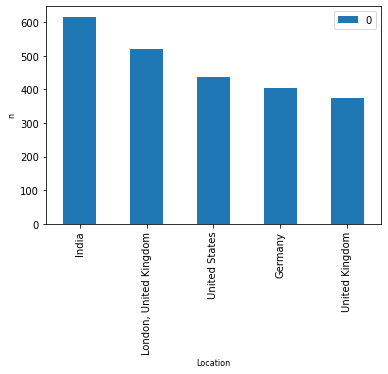

In [0]:
ax = df.plot.bar(rot=90)


ax.set_xlabel("Location", fontsize=8)
ax.set_ylabel("n", fontsize=8)

